 ## NBA Neural Network - in prog

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.spatial.distance import cdist
from numpy.linalg import inv
from sklearn.kernel_ridge import KernelRidge
from bs4 import BeautifulSoup
from urllib.request import urlopen
from pandas.plotting import scatter_matrix
from IPython.display import display
import seaborn as sns
from sklearn.linear_model import LinearRegression
import pymc3 as pm
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
%matplotlib inline
from sklearn.metrics import mean_squared_error
from math import sqrt
import sklearn
from sklearn.neural_network import MLPClassifier

/Users/Sachin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# training data
player_training_data  = []
for i in range(27):
    df = pd.read_csv('2014-draft-class/player{}.csv'.format(i))
    df = df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1)
    player_training_data.append(df)

display(player_training_data[24].head())

#test data
player_test_data = []

for i in range(27):
    df = pd.read_csv('2014-draft-class/player2019_{}.csv'.format(i))
    df = df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1)
    player_test_data.append(df)

# display(player_test_data[24].head())
    

,G,Date,Age,Opp,GS,MP,FG,FGA,FG_Perc,3P,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,1,2015,20,74.33,0,3,1,1,1.000,0,...,0,0,0,0,0,1,0,2,0.7,1
1,2,2015,20,89.27,0,18,5,8,0.625,0,...,6,9,1,0,0,2,3,10,7.8,10
2,3,2015,20,51.92,0,24,4,9,0.444,0,...,1,4,0,0,0,1,2,8,3.9,-2
3,4,2015,20,40.71,0,17,1,4,0.250,0,...,2,3,0,0,1,1,1,5,2.8,-6
4,5,2015,20,37.13,0,17,2,4,0.500,0,...,2,4,1,1,1,1,1,4,4.2,-5


In [3]:
# prepare training data for one player (jokic)
train = player_training_data[24]
train = train[train.PTS != 0]
train = train['PTS'].apply(pd.to_numeric, errors='coerce')
y = np.array(train).flatten()
y_hat = y[3:]
x_features = []
for k in range (3,len(y)):
    temp = np.ones(3)
    for j in range(3):
        temp[j] = y[k-(j+1)]
    x_features.append(temp)
games = np.arange(4, 4 + len(y_hat))
x_cols = np.column_stack((games, x_features))

In [4]:
#prepare test data
test = player_test_data[24]
test = test[test.PTS != 0]
test = test['PTS'].apply(pd.to_numeric, errors='coerce')
y_tst = np.array(test).flatten()
y_hat_tst = y_tst[3:]
x_tst = []
for k in range (3,len(y_tst)):
    temp = np.ones(3)
    for j in range(3):
        temp[j] = y_tst[k-(j+1)]
    x_tst.append(temp)
    
games_tst = np.arange(games[-1] + 4, (games[-1] + 4) + len(y_hat_tst))
x_tst_cols = np.column_stack((games_tst, x_tst))

test = player_test_data[24]
test = test[test.PTS != 0]
features = ['PTS', 'GmSc','FGA']
test = test[features].apply(pd.to_numeric, errors='coerce')

pts = np.array(test.PTS)
gmsc = np.array(test.GmSc)
fga = np.array(test.FGA)
#prev game gmsc
pts_i = pts[1:]
gmsc_prev_i = gmsc[2:-1]
fga_prev_i = fga[2:-1]

x_test = np.column_stack((x_tst_cols, fga_prev_i, gmsc_prev_i))

In [5]:
# y - points for jokic (training data)
train = player_training_data[24]
train = train[train.PTS != 0]
features = ['PTS', 'GmSc']
train = train[features].apply(pd.to_numeric, errors='coerce')

pts = np.array(train.PTS)
gmsc = np.array(train.GmSc)
#prev game gmsc
pts_i = pts[1:]
gmsc_prev_i = gmsc[2:-1]

In [6]:
train = player_training_data[24]
train = train[train.PTS != 0]
features = ['PTS', 'FGA']
train = train[features].apply(pd.to_numeric, errors='coerce')

pts = np.array(train.PTS)
fga = np.array(train.FGA)
#prev game fga
pts_i = pts[1:]
fga_prev_i = fga[2:-1]

In [7]:
x_train = np.column_stack((x_cols, fga_prev_i, gmsc_prev_i))

krr_clf = KernelRidge(alpha=0.5, kernel='rbf', gamma=0.00001, degree=3, coef0=1, kernel_params=None)
clf = krr_clf.fit(x_train, y_hat)

In [8]:
pred = clf.predict(x_test)

rmse = sqrt(mean_squared_error(pred, y_hat_tst))
rmse

8.161850583883512

In [9]:
"""
Multi-feature Kernel Regression
~~~~~~~~~~~~~~~~~~~~~~~~~~

Using the previous game's FGA attempts, previous GmSc,
game no. and the pts scoredfrom the previous 3 games as 
feautures to predict the points scored for the
upcoming game.

"""
a = []
ppg_avg = []
average = []
for i in range(len(player_training_data)):
    train = player_training_data[i]
    train = train[train.PTS != 0]
    train = train['PTS'].apply(pd.to_numeric, errors='coerce')
    y = np.array(train).flatten()
    y_hat = y[3:]
    x_features = []
    for k in range (3,len(y)):
        temp = np.ones(3)
        for j in range(3):
            temp[j] = y[k-(j+1)]
        x_features.append(temp)
    games = np.arange(4, 4 + len(y_hat))
    x_cols = np.column_stack((games, x_features))
    
    train = player_training_data[i]
    train = train[train.PTS != 0]
    features = ['PTS', 'GmSc','FGA']
    train = train[features].apply(pd.to_numeric, errors='coerce')

    pts = np.array(train.PTS)
    gmsc = np.array(train.GmSc)
    fga = np.array(train.FGA)
    #prev game gmsc
    pts_i = pts[1:]
    gmsc_prev_i = gmsc[2:-1]
    fga_prev_i = fga[2:-1]
#     opp_cur = opp[3:]

    x_train = np.column_stack((x_cols, fga_prev_i, gmsc_prev_i))
    
    test = player_test_data[i]
    test = test[test.PTS != 0]
    test = test['PTS'].apply(pd.to_numeric, errors='coerce')
    y_tst = np.array(test).flatten()
    y_hat_tst = y_tst[3:]
    x_tst = []
    for k in range (3,len(y_tst)):
        temp = np.ones(3)
        for j in range(3):
            temp[j] = y_tst[k-(j+1)]
        x_tst.append(temp)

    games_tst = np.arange(games[-1] + 4, (games[-1] + 4) + len(y_hat_tst))
    x_tst_cols = np.column_stack((games_tst, x_tst))

    test = player_test_data[i]
    test = test[test.PTS != 0]
    features = ['PTS', 'GmSc','FGA']
    test = test[features].apply(pd.to_numeric, errors='coerce')

    pts = np.array(test.PTS)
    gmsc = np.array(test.GmSc)
    fga = np.array(test.FGA)
    #prev game gmsc
    pts_i = pts[1:]
    gmsc_prev_i = gmsc[2:-1]
    fga_prev_i = fga[2:-1]
#     opp_cur = opp[3:]

    x_test = np.column_stack((x_tst_cols, fga_prev_i, gmsc_prev_i))
    lr = LinearRegression()
    krr_clf = KernelRidge(alpha=0.5, kernel='rbf', gamma=0.0000075, degree=3, coef0=1, kernel_params=None)
    clf = krr_clf.fit(x_train, y_hat)
    c_lr = lr.fit(x_cols,y_hat)
    pred = clf.predict(x_test)
    p_lr = c_lr.predict(x_tst_cols)
    #print(np.round(np.mean(pred),1))
    ppg_avg.append(np.mean(pred))
    rmse = sqrt(mean_squared_error(pred, y_hat_tst))
    rmse2 = sqrt(mean_squared_error(p_lr,y_hat_tst))
    print(rmse)
    a.append(rmse)
    average.append(rmse2)
    
print("Mean RMSE:{}".format(np.mean(a)))
print("Mean RMSE:{}".format(np.mean(average)))

7.439250072143263
5.3623942594631115
9.634738429976842
5.9031174355923515
4.458541333594716
5.668882331410884
7.564405245962238
3.5314192848534702
5.00400643472244
5.114844186263214
4.3742101205844826
9.762079412580729
7.82688081048712
6.145931212583639
8.096547416114472
4.298102536229955
6.144929544675248
6.414996549855495
6.7716137021458165
4.6728256288771455
5.734011647156768
8.71335846863423
6.0240066858556025
3.413141725697982
8.157730505442778
5.080603015631238
8.05900622105103
Mean RMSE:6.273021267318009
Mean RMSE:6.82556665703413


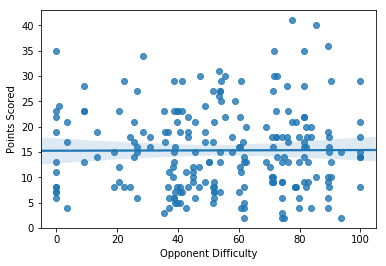

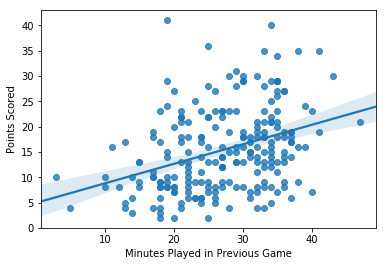

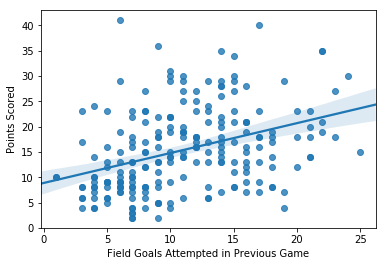

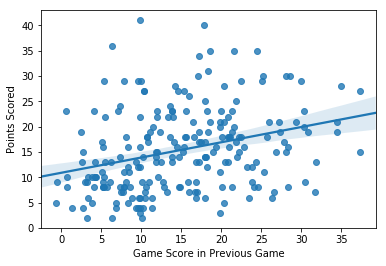

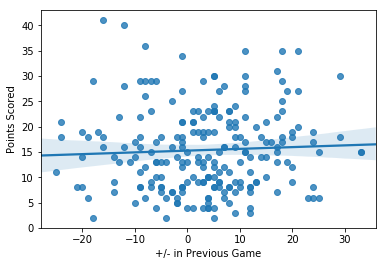

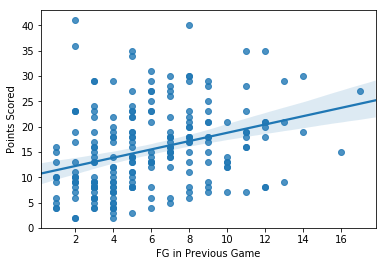

In [10]:
"""
Weighted Least Squares Regression
~~~~~~~~~~~~~~~~~~~~~~~~~~

WLS model, starting with one feature (games played), then build
from there

"""

# player: nikola jokic 
train = player_training_data[24]
train = train[train.PTS != 0]
gmsc = np.array(train['GmSc'])
gmsc = gmsc[:-1]
fga = np.array(train['FGA'])
fga =fga[:-1]
fg = np.array(train['FG'])
fg =fg[:-1]
mp = np.array(train['MP'])
mp = mp[:-1]
opp = np.array(train['Opp'])
pm = np.array(train['+/-'])
pm = pm[:-1]
train = train['PTS']
y = np.array(train)
plt.figure(1)
plt.xlabel('Opponent Difficulty')
plt.ylabel('Points Scored')
sns.regplot(opp,y)
plt.savefig('opp.png')
y = y[1:]

games_played = np.arange(1, len(train)+1)
x = games_played

plt.figure(2)
plt.xlabel('Minutes Played in Previous Game')
plt.ylabel('Points Scored')
sns.regplot(mp,y)
plt.savefig('mp_pts.png')

plt.figure(3)
plt.xlabel('Field Goals Attempted in Previous Game')
plt.ylabel('Points Scored')
sns.regplot(fga,y)
plt.savefig('fga_pts.png')

plt.figure(4)
plt.xlabel('Game Score in Previous Game')
plt.ylabel('Points Scored')
sns.regplot(gmsc,y)
plt.savefig('gmsc_pts.png')

plt.figure(5)
plt.xlabel('+/- in Previous Game')
plt.ylabel('Points Scored')
sns.regplot(pm,y)
plt.savefig('pminus_pts.png')

plt.figure(6)
plt.xlabel('FG in Previous Game')
plt.ylabel('Points Scored')
sns.regplot(fg,y)
plt.savefig('fgoals_pts.png')


In [11]:
## RANDOM STUFF ###
np.set_printoptions(suppress=True)
jokic = player_training_data[24]
jokic = jokic[jokic.PTS != 0]
jokic = jokic.fillna(0)

a, b = 1, 5
x, y = jokic['+/-'].min(), jokic['+/-'].max()
jokic['+/-'] = (jokic['+/-'] - x) / (y - x) * (b - a)

jokic['GmSc'] = jokic['GmSc'] ** 2
jokic['+/-'] = jokic['+/-'] ** 2
jokic.drop(['PTS'],axis=1)

feature_array = np.array(jokic.drop(['PTS'],axis=1))
feature_array = feature_array[3:]
feature_array.T[0] = np.arange(4,4+len(feature_array))


prev_pts = jokic[jokic.PTS != 0]
prev_pts = prev_pts['PTS'].apply(pd.to_numeric, errors='coerce')
y = np.array(prev_pts).flatten()

y_hat = y[3:]
x_features = []
for k in range (3,len(y)):
    temp = np.ones(3)
    for j in range(3):
        temp[j] = y[k-(j+1)]
    x_features.append(temp)
    
x_features = np.array(x_features)
print(x_features.shape)
print(feature_array.shape)

last_3_games = []
for games in x_features:
    t = np.mean(games)
    last_3_games.append(t)
l3g = np.array(last_3_games)

feature_array.T[1] = l3g

(219, 3)
(219, 25)


In [12]:
#### FINDING BEST FEATURES USNIG SELECT-K-BEST AS WELL AS LOOKING AT PCA ########


import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn import preprocessing
from pandas.tools.plotting import table

X = pd.DataFrame(feature_array).apply(pd.to_numeric,errors='coerce')
x, y = jokic['+/-'].min(), jokic['+/-'].max()
display(X.head())
data_scaled = pd.DataFrame(preprocessing.scale(X), columns=X.columns)

pca = PCA(n_components=0.8)
pca_ft = pca.fit_transform(data_scaled)

# print(pd.DataFrame(pca.components_,columns=X.columns,index = ['PCA1','PCA2','PCA3','PCA4','PCA5','PCA6','PCA7','PCA8','PCA9','PCA10']))
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2

# print(X)
X = feature_array
jokic = player_training_data[24]
resp = jokic[jokic.PTS != 0]
resp = resp['PTS'].apply(pd.to_numeric, errors='coerce')
y = resp[3:]
# print(y.shape)

X = X[:-1]
y = y[1:]

X_new = SelectKBest(chi2, k=4).fit_transform(X, y)

X_new


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,4.0,6.666667,20.0,40.71,0.0,17.0,1.0,4.0,0.250,0.0,...,1.0,2.0,3.0,0.0,0.0,1.0,1.0,1.0,7.84,1.717004
1,5.0,7.666667,20.0,37.13,0.0,17.0,2.0,4.0,0.500,0.0,...,2.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0,17.64,1.902497
2,6.0,5.666667,20.0,70.98,0.0,15.0,3.0,3.0,1.000,0.0,...,0.0,2.0,2.0,1.0,2.0,0.0,1.0,2.0,112.36,2.739596
3,7.0,6.333333,20.0,78.61,0.0,14.0,4.0,7.0,0.571,0.0,...,3.0,2.0,5.0,4.0,2.0,0.0,2.0,0.0,96.04,5.498216
4,8.0,7.333333,20.0,74.33,0.0,5.0,1.0,3.0,0.333,0.0,...,2.0,3.0,5.0,0.0,0.0,0.0,1.0,2.0,1.96,4.280618


array([[   4.  ,   40.71,    4.  ,    7.84],
       [   5.  ,   37.13,    4.  ,   17.64],
       [   6.  ,   70.98,    3.  ,  112.36],
       [   7.  ,   78.61,    7.  ,   96.04],
       [   8.  ,   74.33,    3.  ,    1.96],
       [   9.  ,   79.78,    3.  ,   50.41],
       [  10.  ,    0.01,   13.  ,  696.96],
       [  11.  ,   79.78,    6.  ,   26.01],
       [  12.  ,   37.13,    7.  ,  210.25],
       [  13.  ,   39.08,   13.  ,   98.01],
       [  14.  ,    0.01,    4.  ,    0.64],
       [  15.  ,   61.72,    3.  ,   32.49],
       [  16.  ,   78.61,    7.  ,   56.25],
       [  17.  ,   60.17,    6.  ,   27.04],
       [  18.  ,   51.45,    7.  ,   47.61],
       [  19.  ,   61.64,    6.  ,    6.25],
       [  20.  ,   89.27,   10.  ,  282.24],
       [  21.  ,   74.33,    3.  ,  110.25],
       [  22.  ,   89.27,    4.  ,   59.29],
       [  23.  ,   40.71,    5.  ,   30.25],
       [  24.  ,   82.66,    8.  ,  144.  ],
       [  25.  ,  100.01,    7.  ,  295.84],
       [  

,games_pl,prev_points,2,opp,4,5,fga,7,8,9,...,15,16,fg,18,19,20,21,22,gmsc,plus_minus
0,4.0,6.666667,20.0,40.71,0.0,17.0,1.0,4.0,0.250,0.0,...,1.0,2.0,3.0,0.0,0.0,1.0,1.0,1.0,7.84,1.717004
1,5.0,7.666667,20.0,37.13,0.0,17.0,2.0,4.0,0.500,0.0,...,2.0,2.0,4.0,1.0,1.0,1.0,1.0,1.0,17.64,1.902497
2,6.0,5.666667,20.0,70.98,0.0,15.0,3.0,3.0,1.000,0.0,...,0.0,2.0,2.0,1.0,2.0,0.0,1.0,2.0,112.36,2.739596
3,7.0,6.333333,20.0,78.61,0.0,14.0,4.0,7.0,0.571,0.0,...,3.0,2.0,5.0,4.0,2.0,0.0,2.0,0.0,96.04,5.498216
4,8.0,7.333333,20.0,74.33,0.0,5.0,1.0,3.0,0.333,0.0,...,2.0,3.0,5.0,0.0,0.0,0.0,1.0,2.0,1.96,4.280618


/Users/Sachin/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Sachin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


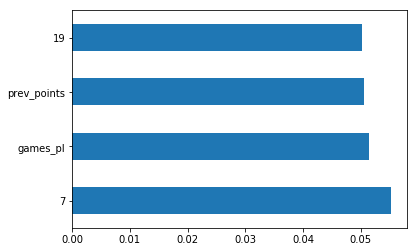

In [13]:
# X = array of feautures and y = target variable
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()

# X = X[:-1]
# y = y[1:]
X = pd.DataFrame(X)
y = pd.DataFrame(y)

X = X.rename(columns={0: 'games_pl', 1: 'prev_points',24:'plus_minus', 23: 'gmsc', 6: 'fga', 3 :'opp', 17: 'fg'})
display(X.head())
model.fit(X,y)
# print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_,index=X.columns)
feat_importances.nlargest(4).plot(kind='barh')
plt.savefig('thesis/extratreeclf.png')
plt.show()

In [180]:
import sys
display(X.shape)

(218, 25)

In [16]:
y[1:]

5      10
6       8
7       3
8       4
10     23
11      6
12     11
13     16
14      6
15      8
16      8
17      7
18      8
19      4
20     19
21      9
22      6
23      7
24     13
25     15
26     13
27     22
28      7
29     10
30     10
32      9
33      4
34      9
35      4
36      6
       ..
198    19
199    15
200    14
201    21
202    23
203    30
204    28
205    21
206    18
207     9
208     9
209     4
210    36
211    21
212    20
213    15
214    23
215    17
216    34
217    21
218    25
219    14
220    29
221    23
222    35
223    30
224    16
225    23
226    15
227    35
Name: PTS, Length: 217, dtype: int64